# DELCODE WMH Segmentation Pipeline

In [5]:
from IPython.display import Image

In [ ]:
Image('./imgs/tree.png') 

# Integrating in another workflow

We want to segment the WMHs in our dataset while integrating our sysu_media implementation in a bigger preprocessing workflow.

Every FLAIR should be:
1. Brain Extracted (FSL bet)
2. Denoised with spatial-adaptive Non-Local Means (SANLM) filter (CAT12)

the result can be given as an input to sysu_media

In [8]:
from nipype.pipeline.engine import Workflow, Node

In [9]:
from wmhpypes.interfaces import cat12
from wmhpypes.interfaces import misc
from nipype.interfaces import fsl

In [10]:
models_dir = '../models' # Folder containing the models as .h5  
dataset_dir = './test_dataset' # Folder containing the dataset
out_dir =  './out' # Folder where we want to save the outputs 
temp_dir = './tmp' # Folder for the workflow's temporary files

In [12]:
delcode = Workflow(name='delcode', base_dir=temp_dir)

bet = Node(interface=fsl.BET(reduce_bias=True,
                             frac=.2,
                             output_type='NIFTI'), name='bet')
denoising = Node(interface=cat12.CAT12SANLMDenoising(), name='denoising')

delcode.connect(bet, 'out_file', denoising, 'in_files')

211017-22:06:45,977 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI


stty: 'standard input': Inappropriate ioctl for device


211017-22:06:52,306 nipype.workflow INFO:
	 Generated workflow graph: ./imgs/delcode.png (graph2use=colored, simple_form=True).


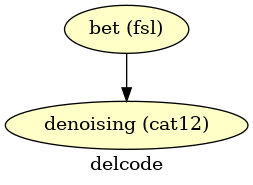

In [13]:
delcode.write_graph(graph2use='colored', dotfilename='./imgs/delcode.dot')
Image('./imgs/delcode.png')

## 1. Install WMHPypes

In [14]:
%%bash
#git clone https://github.com/0rC0/WMHpypes.git
#cd WMHpypes
#conda create -n wmhpypes pip --yes
#conda activate wmhpypes
#pip install --quiet -r requirements.txt
#pip install . --quiet
# cd ..

211017-22:06:53,580 nipype.workflow INFO:
	 Generated workflow graph: ./imgs/nn.png (graph2use=colored, simple_form=True).


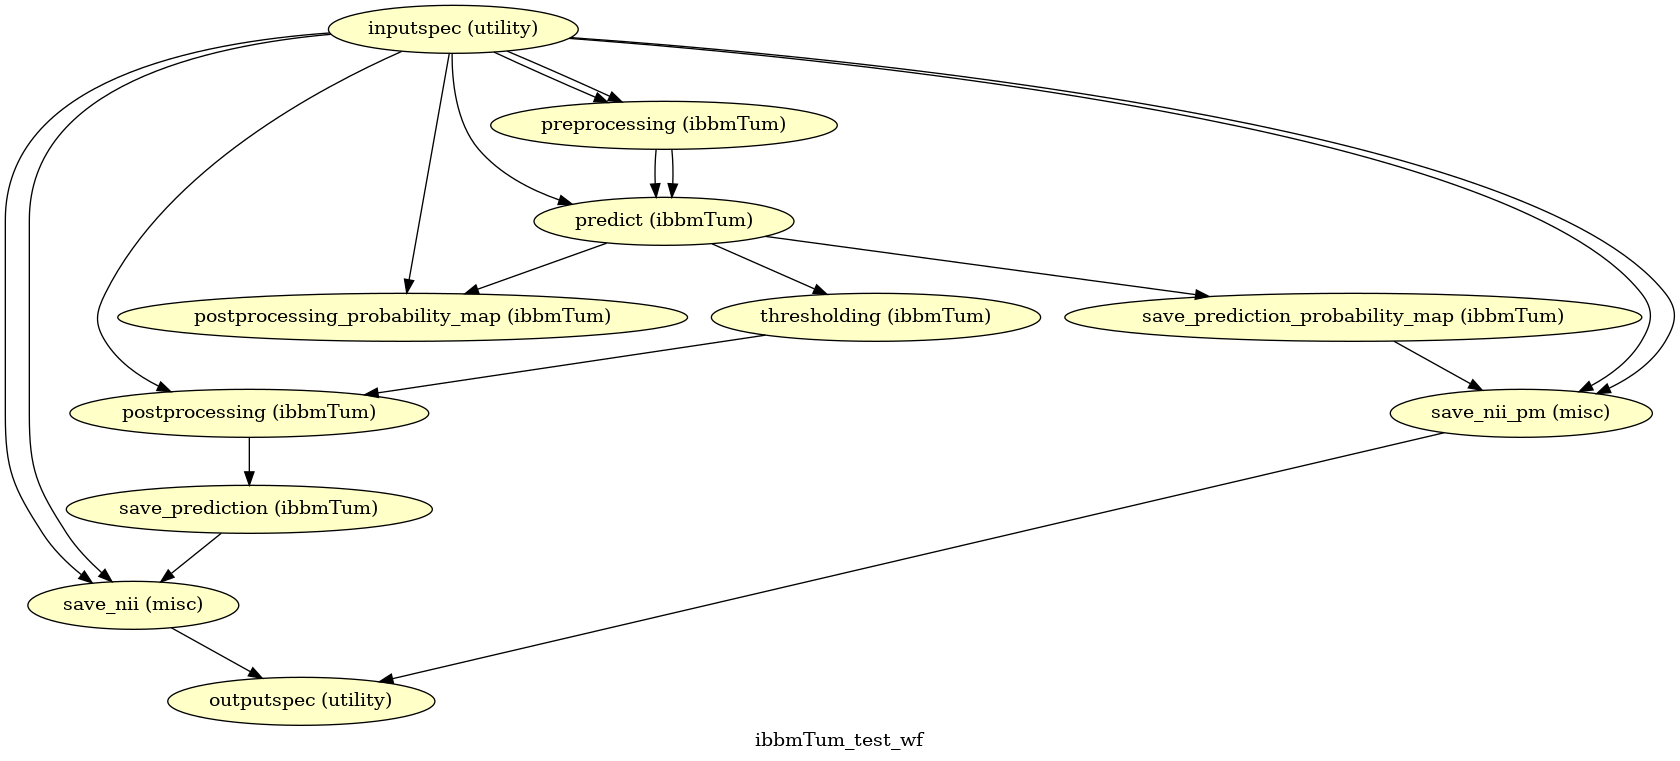

In [15]:
from wmhpypes.workflows import ibbmTum_wf
test_wf = ibbmTum_wf.get_test_wf(row_st=192,
                                     cols_st=192,
                                     thres_mask=10)
test_wf.write_graph(graph2use='colored', dotfilename='./imgs/nn.dot')
Image('./imgs/nn.png', width=600)

predictionThe inputspec accept as inputs:

1. flair
2. weights

The outputspec returns as an output:

1. wmh_mask

In [16]:
from nipype import DataGrabber, DataSink, IdentityInterface

In [17]:
#Subject IDs
import os
sub_ids = [i.strip('flair_').strip('.nii.gz') for i in os.listdir(os.path.join(dataset_dir, 'flair'))]
data_source = Node(interface=IdentityInterface(fields = ['weights', 'sub-id']), name='data_source')
data_source.iterables = ('sub-id', sub_ids)
data_source.inputs.weights = [os.path.join(os.getcwd(), models_dir, i) for i in os.listdir(models_dir)]

In [18]:
data_grabber = Node(interface=DataGrabber(infields=['sub-id'],
                                          outfields=['flair']), name='data_grabber')
data_grabber.inputs.base_directory = os.path.abspath('./test_dataset')
data_grabber.inputs.template = 'flair/flair_%s.nii.gz'
data_grabber.inputs.template_args = {'flair' : [['sub-id']]}
data_grabber.inputs.sort_filelist = False

In [19]:
delcode.connect(data_source, 'sub-id', data_grabber, 'sub-id')
delcode.connect(data_grabber, 'flair', bet, 'in_file')
delcode.connect(denoising, 'out_file', test_wf, 'inputspec.flair')
delcode.connect(data_source, 'weights', test_wf, 'inputspec.weights')

211017-22:06:53,874 nipype.workflow INFO:
	 Generated workflow graph: ./imgs/delcode.png (graph2use=colored, simple_form=True).


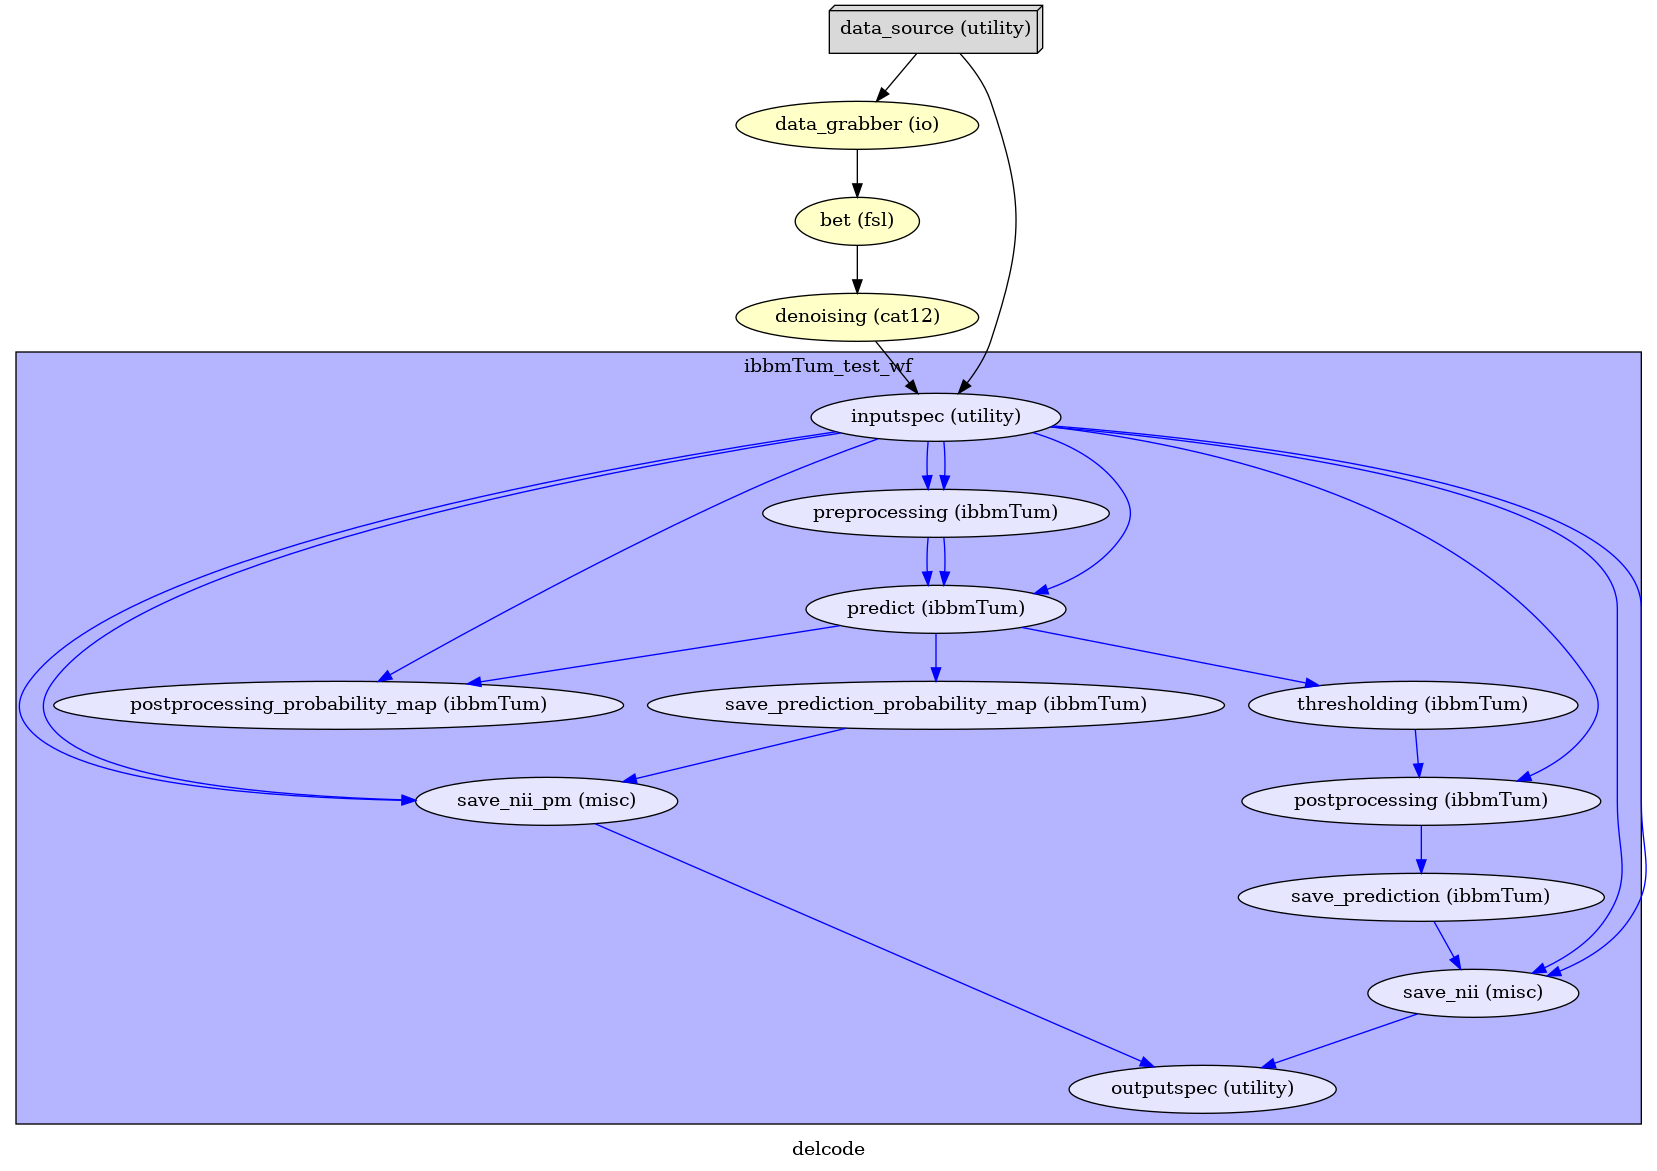

In [20]:
from IPython.display import Image
delcode.write_graph(graph2use='colored', dotfilename='./imgs/delcode.dot')
Image('./imgs/delcode.png', width=600)

In [21]:
sink = Node(interface=DataSink(), name = 'sink')
sink.inputs.base_directory = os.path.abspath(out_dir)

In [22]:
delcode.connect(test_wf, 'outputspec.wmh_mask', sink, '@wmh_mask')
delcode.connect(test_wf, 'outputspec.wmh_probability_map', sink, '@wmh_probability_mask')

211017-22:06:54,150 nipype.workflow INFO:
	 Generated workflow graph: ./imgs/delcode.png (graph2use=colored, simple_form=True).


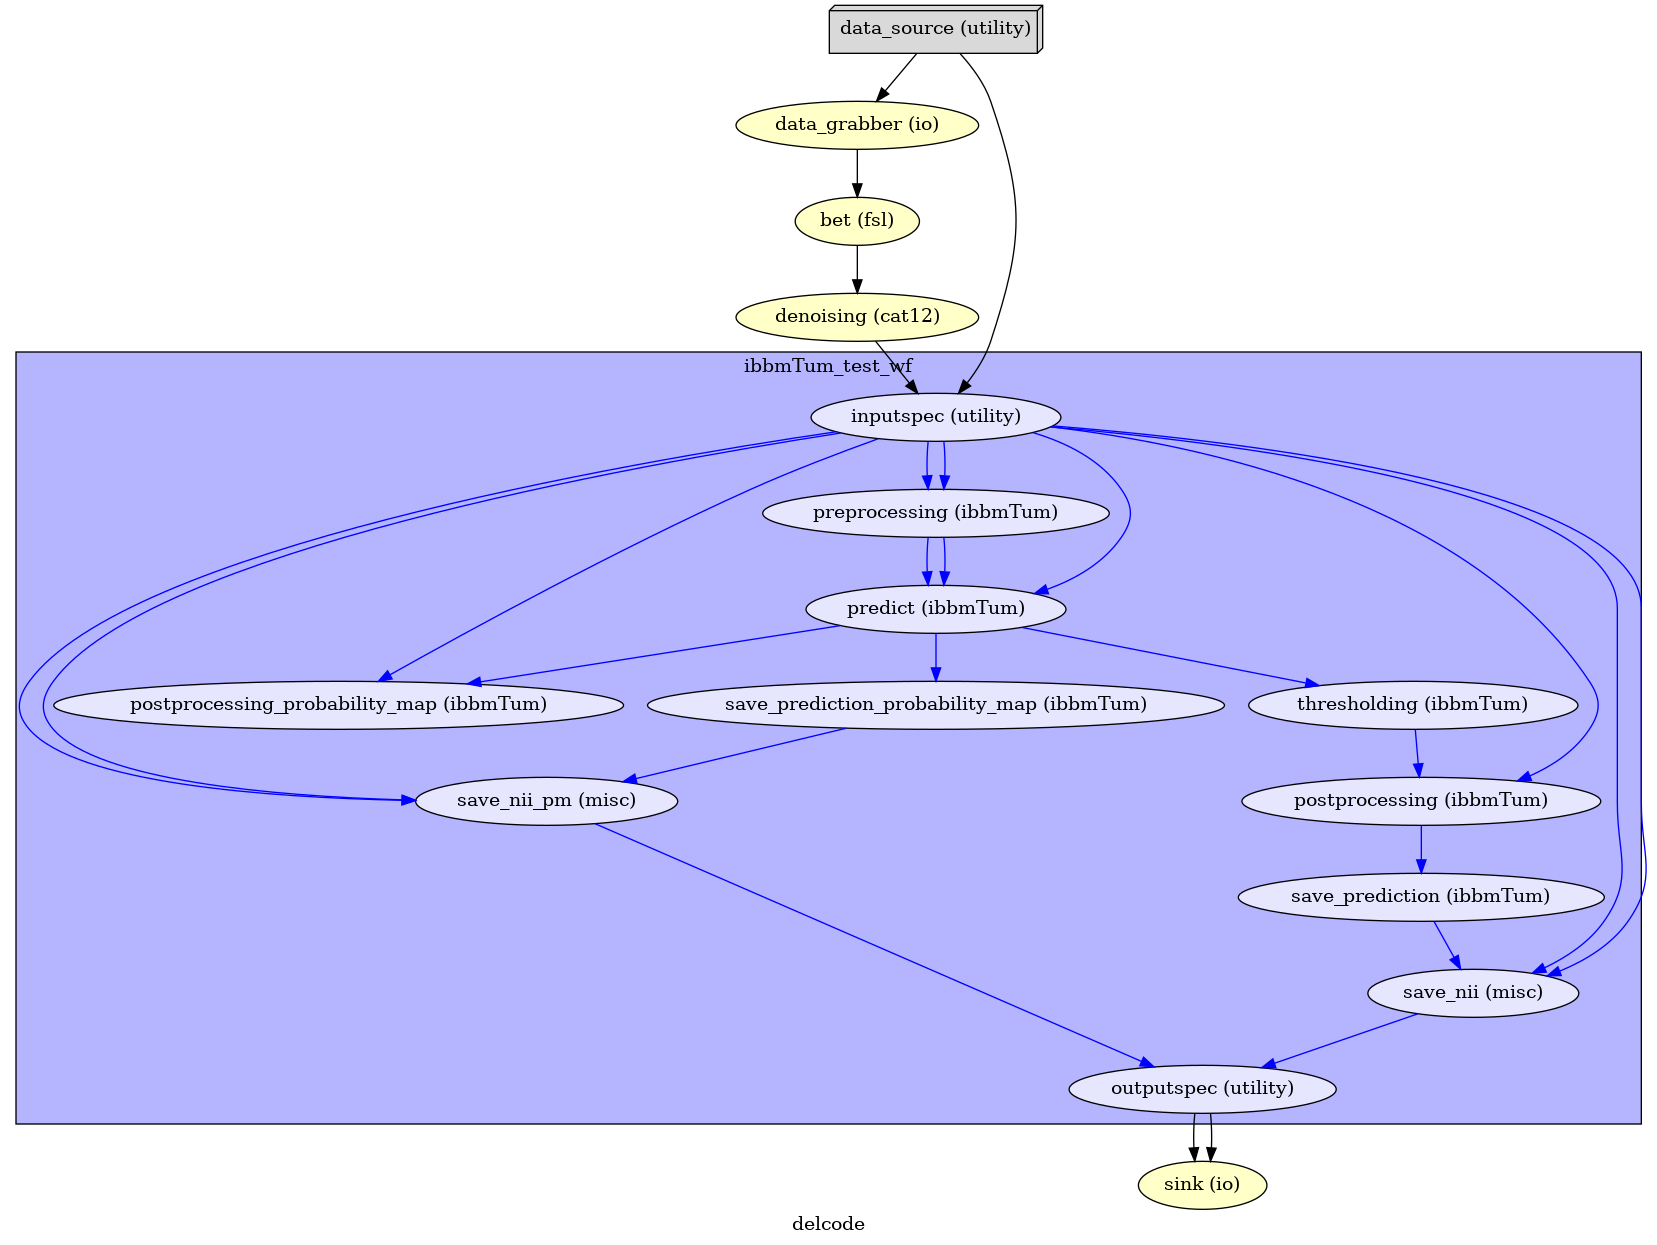

In [23]:
from IPython.display import Image
delcode.write_graph(graph2use='colored', dotfilename='./imgs/delcode.dot')
Image('./imgs/delcode.png', width=600)

In [24]:
# Run it

In [25]:
# we are now ready to run the pipeline

In [26]:
plugin_args = {'n_procs': 5}
delcode.run(plugin='MultiProc', plugin_args=plugin_args)

211017-22:06:54,184 nipype.workflow INFO:
	 Workflow delcode settings: ['check', 'execution', 'logging', 'monitoring']
211017-22:06:54,193 nipype.workflow INFO:
	 Running in parallel.
211017-22:06:54,195 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 28.14/28.14, Free processors: 5/5.
211017-22:06:54,285 nipype.workflow INFO:
	 [Node] Setting-up "delcode.data_grabber" in "/media/orco/home_data/Dokumente/DZNE/WMHpypes/examples/tmp/delcode/_sub-id_01dc83c85M0_T1_01_1/data_grabber".
211017-22:06:54,288 nipype.workflow INFO:
	 [Node] Running "data_grabber" ("nipype.interfaces.io.DataGrabber")
211017-22:06:54,293 nipype.workflow INFO:
	 [Node] Finished "delcode.data_grabber".
211017-22:06:56,198 nipype.workflow INFO:
	 [Job 0] Completed (delcode.data_grabber).
211017-22:06:56,200 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 28.14/28.14, Free processors: 5/5.
211017-22:06:56,295 nipype.workflow INFO:
	 [Nod

stty: 'standard input': Inappropriate ioctl for device


211017-22:13:34,675 nipype.workflow INFO:
	 [Node] Setting-up "delcode.ibbmTum_test_wf.preprocessing" in "/media/orco/home_data/Dokumente/DZNE/WMHpypes/examples/tmp/delcode/ibbmTum_test_wf/_sub-id_01dc83c85M0_T1_01_1/preprocessing".
211017-22:13:34,678 nipype.workflow INFO:
	 [Node] Running "preprocessing" ("wmhpypes.interfaces.ibbmTum.Preprocessing")
211017-22:13:36,596 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 27.94/28.14, Free processors: 4/5.
                     Currently running:
                       * delcode.ibbmTum_test_wf.preprocessing
211017-22:13:41,558 nipype.workflow INFO:
	 [Node] Finished "delcode.ibbmTum_test_wf.preprocessing".
211017-22:13:42,603 nipype.workflow INFO:
	 [Job 3] Completed (delcode.ibbmTum_test_wf.preprocessing).
211017-22:13:42,605 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 28.14/28.14, Free processors: 5/5.
211017-22:13:42,682 nipype.workflow INFO:
	 [Node] 

2021-10-17 22:13:55.056171: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-17 22:13:55.056424: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-17 22:13:55.058133: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2021-10-17 22:13:55.279136: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-17 22:13:55.297687: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3593095000 Hz


256/256 [==============================] - ETA: 44 - ETA: 29 - ETA: 29 - ETA: 34 - ETA: 32 - ETA: 34 - ETA: 36 - ETA: 37 - ETA: 37 - ETA: 38 - ETA: 38 - ETA: 38 - ETA: 38 - ETA: 37 - ETA: 38 - ETA: 37 - ETA: 37 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 35 - ETA: 36 - ETA: 36 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 24 - ETA: 24

sizeof_hdr should be 540; set sizeof_hdr to 540


211017-22:16:08,258 nipype.workflow INFO:
	 [Node] Running "postprocessing" ("wmhpypes.interfaces.ibbmTum.Postprocessing")
211017-22:16:08,323 nipype.workflow INFO:
	 [Node] Finished "delcode.ibbmTum_test_wf.save_nii_pm".
211017-22:16:08,719 nipype.workflow INFO:
	 [Job 9] Completed (delcode.ibbmTum_test_wf.save_nii_pm).
211017-22:16:08,721 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 27.94/28.14, Free processors: 4/5.
                     Currently running:
                       * delcode.ibbmTum_test_wf.postprocessing
211017-22:16:09,296 nipype.workflow INFO:
	 [Node] Finished "delcode.ibbmTum_test_wf.postprocessing".
211017-22:16:10,722 nipype.workflow INFO:
	 [Job 8] Completed (delcode.ibbmTum_test_wf.postprocessing).
211017-22:16:10,723 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 28.14/28.14, Free processors: 5/5.
211017-22:16:10,799 nipype.workflow INFO:
	 [Node] Setting-up "delcode.ibbmTum_

sizeof_hdr should be 540; set sizeof_hdr to 540


211017-22:16:13,319 nipype.workflow INFO:
	 [Node] Finished "delcode.ibbmTum_test_wf.save_nii".
211017-22:16:14,726 nipype.workflow INFO:
	 [Job 11] Completed (delcode.ibbmTum_test_wf.save_nii).
211017-22:16:14,728 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 28.14/28.14, Free processors: 5/5.
211017-22:16:14,804 nipype.workflow INFO:
	 [Node] Setting-up "delcode.sink" in "/media/orco/home_data/Dokumente/DZNE/WMHpypes/examples/tmp/delcode/_sub-id_01dc83c85M0_T1_01_1/sink".
211017-22:16:14,809 nipype.workflow INFO:
	 [Node] Running "sink" ("nipype.interfaces.io.DataSink")
211017-22:16:14,812 nipype.workflow INFO:
	 [Node] Finished "delcode.sink".
211017-22:16:16,729 nipype.workflow INFO:
	 [Job 12] Completed (delcode.sink).
211017-22:16:16,730 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 0 jobs ready. Free memory (GB): 28.14/28.14, Free processors: 5/5.


In [ ]:
!fsleyes /home/dellorcoa/Documents/DZNE/WMHpypes/workshop/test_dataset/flair/flair_01dc83c85M0_T1_01_1.nii.gz \
/home/dellorcoa/Documents/DZNE/WMHpypes/workshop/delcode/delcode/_sub-id_01dc83c85M0_T1_01_1/bet/flair_01dc83c85M0_T1_01_1_brain.nii \
/home/dellorcoa/Documents/DZNE/WMHpypes/workshop/delcode/delcode/_sub-id_01dc83c85M0_T1_01_1/denoising/sanlm_flair_01dc83c85M0_T1_01_1_brain.nii \
/home/dellorcoa/Documents/DZNE/WMHpypes/workshop/out/_sub-id_01dc83c85M0_T1_01_1/prediction.nii.gz